# **Flag Classification**

---

#### **Introduction**

Flags are not merely symbols of national pride and identity; they encapsulate the stories, cultures, histories, and ideals of nations. The design elements of flags—colors, symbols, patterns—serve as a visual language, offering insights into the geographical, historical, and cultural contexts of countries. This project leverages a comprehensive dataset collected from the "Collins Gem Guide to Flags" (Collins Publishers, 1986) to explore and classify flags using machine learning techniques. By examining various attributes of flags, this project aims to uncover the underlying patterns that link flag designs with the nations they represent.

---

#### **Description**

The country flag dataset has a diverse range of features make it well suited for machine learning classification tasks. Each entry in the dataset corresponds to a country or territory's flag, with 30 features that detail color, composition, and symbolic elements of the flag's design and summarize geographical, linguistic, religious, and demographic information about the nation itself. 

Through the analysis of flag attributes and the application of machine learning techniques, this project aims to reveal the intricate connections between nations' identities and their flags, offering a unique perspective on global diversity.

**Note:** This dataset was compiled in between 1986-1990 so some of the information, primarily population size, is decades out of date and several country flags have since been updated or retired.

##### **Feature Information**

|     |     |     |
| --: | --- | --- |
|  1. | name | Name of the country (or territory) |
|  2. | landmass | 1=North America, 2=South America, 3=Europe, 4=Africa, 5=Asia, 6=Oceania |
|  3. | zone | Geographic quadrant, based on Greenwich and the Equator 1=NE, 2=SE, 3=SW, 4=NW |
|  4. | area | in thousands of square km |
|  5. | population | in millions (rounded) |
|  6. | language | 1=English, 2=Spanish, 3=French, 4=German, 5=Slavic, 6=Other Indo-European, 7=Chinese, 8=Arabic, 9=Japanese/Turkish/Finnish/Magyar, 10=Others |
|  7. | religion | 0=Catholic, 1=Other Christian, 2=Muslim, 3=Buddhist, 4=Hindu, 5=Ethnic, 6=Marxist, 7=Others |
|  8. | bars | Number of vertical bars in the flag |
|  9. | stripes | Number of horizontal stripes in the flag |
| 10. | colors | Number of different colors in the flag |
| 11. | red | 0 if red absent, 1 if red present in the flag |
| 12. | green | ^^ |
| 13. | blue | ^^ |
| 14. | gold | ^^ (also yellow) |
| 15. | white | ^^ |
| 16. | black | ^^ |
| 17. | orange |  ^^ (also brown) |
| 18. | mainhue | Predominant color in the flag (tie-breaks decided by taking the topmost hue, if that fails then the most central hue, and if that fails the leftmost hue) |
| 19. | circles |  Number of circles in the flag |
| 20. | crosses | Number of upright crosses |
| 21. | saltires | Number of diagonal crosses |
| 22. | quarters | Number of quartered sections |
| 23. | sunstars | Number of sun or star symbols |
| 24. | crescent | 1 if a crescent moon symbol present, else 0 |
| 25. | triangle | 1 if any triangles present, 0 otherwise |
| 26. | icon | 1 if an inanimate image present (e.g., a boat), otherwise 0 |
| 27. | animate | 1 if an animate image (e.g., an eagle, a tree, a human hand) present, 0 otherwise |
| 28. | text | 1 if any letters or writing on the flag (e.g., a motto or slogan), 0 otherwise |
| 29. | topleft | Color in the top-left corner (moving right to decide tie-breaks) |
| 30. | botright | Color in the bottom-right corner (moving left to decide tie-breaks) |


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

## Data Visualization

---

Spend some time getting familiar with the data. Make visualizations to get an idea of the spread and variety of features in the dataset. 

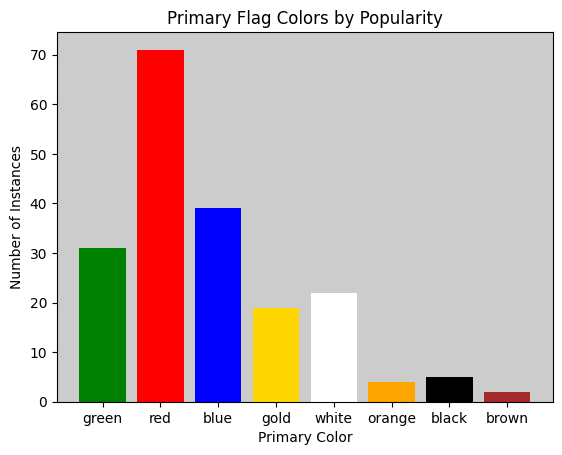

In [26]:
df = pd.read_csv('flag_data.csv')
hues = df['mainhue'].unique()
vals = [df['mainhue'].value_counts()[hue] for hue in hues]

plt.axes().set_facecolor('#ccc')
plt.bar(hues, vals, align='center', color=hues)
plt.title('Primary Flag Colors by Popularity')
plt.xlabel('Primary Color')
plt.ylabel('Number of Instances')
plt.show()

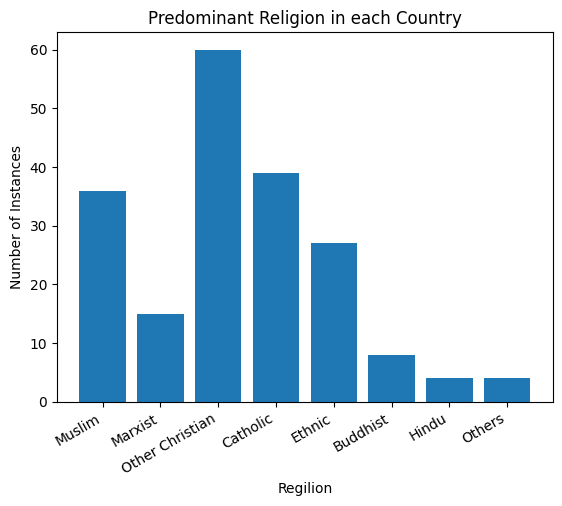

In [31]:
religions = df['religion'].unique()
vals = [df['religion'].value_counts()[religion] for religion in religions]

plt.bar(religions, vals, align='center')
plt.title('Predominant Religion in each Country')
plt.xlabel('Regilion')
plt.ylabel('Number of Instances')
plt.xticks(rotation=30, ha='right')
plt.show()

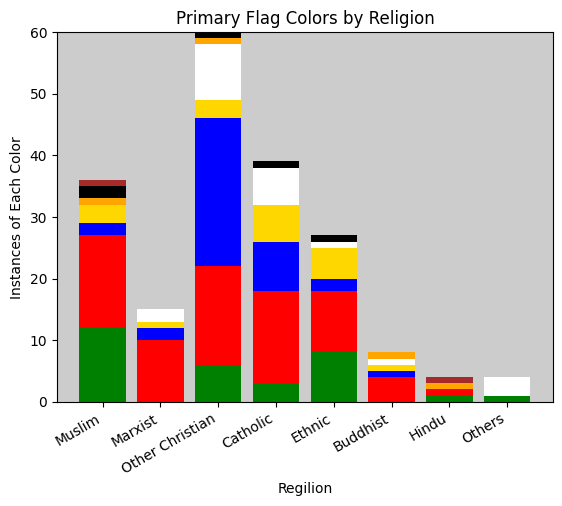

In [29]:
plt.axes().set_facecolor('#ccc')
bottoms = len(religions) * [0]
for hue in hues:
    values = [len(df[(df['religion'] == religion) & (df['mainhue'] == hue)]) for religion in religions]
    plt.bar(religions, values, bottom=bottoms, color=hue)
    bottoms = [bottoms[i]+values[i] for i in range(len(religions))]

plt.title('Primary Flag Colors by Religion')
plt.xlabel('Regilion')
plt.ylabel('Instances of Each Color')
plt.xticks(rotation=30, ha='right')
plt.show()

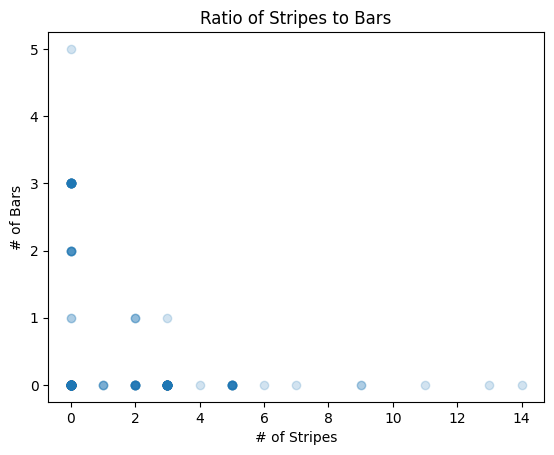

In [37]:
plt.scatter(df['stripes'],df['bars'], alpha=0.2)
plt.title('Ratio of Stripes to Bars')
plt.xlabel('# of Stripes')
plt.ylabel('# of Bars')
plt.show()

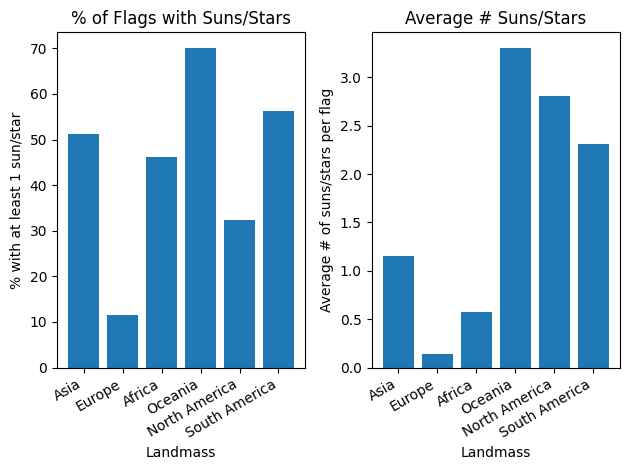

In [58]:
landmasses = df['landmass'].unique()
percents = []
averages = []
for lm in landmasses:
    group = df[df['landmass'] == lm]
    
    with_stars = group[group['sunstars'] > 0]
    percents.append(100 * len(with_stars) / len(group))

    star_sum = group['sunstars'].sum()
    averages.append(star_sum / len(group))

plt.subplot(1,2,1)
plt.bar(landmasses, percents)
plt.title('% of Flags with Suns/Stars')
plt.xlabel('Landmass')
plt.ylabel('% with at least 1 sun/star')
plt.xticks(rotation=30, ha='right')

plt.subplot(1,2,2)
plt.bar(landmasses, averages)
plt.title('Average # Suns/Stars')
plt.xlabel('Landmass')
plt.ylabel('Average # of suns/stars per flag')
plt.xticks(rotation=30, ha='right')

plt.tight_layout()
plt.show()

## Classification

---



In [96]:
# Categorical Data Labels

landmasses = {1:'North America', 2:'South America', 3:'Europe', 4:'Africa', 5:'Asia', 6:'Oceania'}
zones = {1:'NE', 2:'SE', 3:'SW', 4:'NW'}
languages = {1:'English', 2:'Spanish', 3:'French', 4:'German', 5:'Slavic', 6:'Other Indo-European', 7:'Chinese', 8:'Arabic', 9:'Japanese/Turkish/Finnish/Magyar', 10:'Others'}
religions = {0:'Catholic', 1:'Other Christian', 2:'Muslim', 3:'Buddhist', 4:'Hindu', 5:'Ethnic', 6:'Marxist', 7:'Others'}
colors = {'red':1, 'green':2, 'blue':3, 'gold':4, 'white':5, 'black':6, 'orange':7, 'brown':8}

attr_names = {'landmass':landmasses, 'zone':zones, 'language':languages, 'religion':religions, 'mainhue':colors, 'topleft':colors, 'botright':colors}

In [313]:
df = pd.read_csv("flag_data_cleaned.csv")
df

,name,landmass,zone,area,population,language,religion,bars,stripes,colors,...,saltires,quarters,sunstars,cresent,triangle,icon,animate,text,topleft,botright
0,Afghanistan,5,1,648,16,10,2,0,3,5,...,0,0,1,0,0,1,0,0,6,2
1,Albania,3,1,29,3,6,6,0,0,3,...,0,0,1,0,0,0,1,0,1,1
2,Algeria,4,1,2388,20,8,2,2,0,3,...,0,0,1,1,0,0,0,0,2,5
3,American Samoa,6,3,0,0,1,1,0,0,5,...,0,0,0,0,1,1,1,0,3,1
4,Andorra,3,1,0,0,6,0,3,0,3,...,0,0,0,0,0,0,0,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,Western Samoa,6,3,3,0,1,1,0,0,3,...,0,1,5,0,0,0,0,0,3,1
189,Yugoslavia,3,1,256,22,6,6,0,3,4,...,0,0,1,0,0,0,0,0,3,1
190,Zaire,4,2,905,28,10,5,0,0,4,...,0,0,0,0,0,1,1,0,2,2
191,Zambia,4,2,753,6,10,5,3,0,4,...,0,0,0,0,0,0,1,0,2,8


### Train to Predict Landmass

In [314]:
target = 'landmass'
target_col = df[target]
target_names = attr_names[target]

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=[target]), target_col, test_size=0.2, random_state=32)

# Drop the names after splitting the data so that they can be
# re-paired with the data for analysis after training and testing
train_names = X_train['name']
X_train = X_train.drop(columns=['name'])

test_names = X_test['name']
X_test = X_test.drop(columns=['name'])

In [326]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)

print(metrics.accuracy_score(pred,y_test))
print(metrics.precision_score(pred,y_test, average='macro'))
print(metrics.recall_score(pred,y_test, average='macro'))

0.9230769230769231
0.9526143790849674
0.9097222222222223


In [327]:
"""
Get the flag images for the specified countries from img_links.csv
Return as a list of HTML formatted strings
"""
def flag_column(countries, image_size=150):
    data = pd.read_csv("img_links.csv")
    flag_data = []
    for country in countries:
        row = data.loc[data['name'] == country]
        html = html_img(row['image'][row.index[0]], row['year'][row.index[0]], image_size)
        flag_data.append(html)
    return flag_data


"""
Create an HTML image tag using the flag's image url, set the img width
Add the year/version of the flag as small font below the image
Return as one string
"""
def html_img(link, year, size):
    img = f'<img src="{link}" width={size} /><br>'
    font = f'<font size=1><i>({year})</i></font>'
    return img + font


"""
- Center year text under flag image
- Make country names bold
- Highlight incorrect predictions in red
"""
def output_styling(column, actual_col):
    if 'flag' in column.name.lower():
        return ['text-align: center' for val in column]
    elif 'name' in column.name.lower() or 'country' in column.name.lower():
        return ['font-weight: bold' for val in column]
    return ['color: red' if column[idx] != actual_col[idx] else 'color: default' for idx in column.index]

In [328]:
results_df = pd.DataFrame()
results_df.insert(0, 'Country', test_names)
results_df.insert(1, 'Actual', [target_names[x] for x in y_test])
results_df.insert(2, 'Predicted', [target_names[x] for x in pred])
results_df.insert(0, 'Flag', flag_column(test_names))

output = results_df.style.apply(output_styling, actual_col=results_df['Actual'])

# add a 'title' to specify targeted feature and display styled table
from IPython.display import display, HTML
display(HTML(f'<h2>{target.capitalize()}</h2>' + output.to_html()))

,Flag,Country,Actual,Predicted
27,(1974),Burma,Asia,Asia
141,(1866),Romania,Europe,Europe
140,(1949),Qatar,Asia,Asia
34,(1959),Chad,Africa,Africa
57,(1918),Finland,Europe,Europe
176,(1978),Tuvalu,Oceania,Oceania
2,(1962),Algeria,Africa,Africa
79,(1915),Iceland,Europe,North America
73,(1961),Guinea-Bissau,Africa,Africa
85,(1897),Israel,Asia,Asia


### Train to Predict the Presence of a Color

In [287]:
df = pd.read_csv("flag_data_cleaned.csv")
target = 'green'
target_col = df[target]

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=[target, 'name']), target_col, test_size=0.2, random_state=56)

model = RandomForestClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)

print(metrics.accuracy_score(pred,y_test))
print(metrics.precision_score(pred,y_test, average='macro'))
print(metrics.recall_score(pred,y_test, average='macro'))

1.0
1.0
1.0


## Dataset

---

The design of a flag can tell us a lot about the nation's culture, history, and environment. Explore the dataset as a whole to find any trends and patterns. Feel free to search the web for background info if a particular design piques your interest and want to learn more. Make note of the year listed under the flag as some countries have since updated their national flag.

In [335]:
df = pd.read_csv("flag_data.csv")
df.insert(1, 'flag', flag_column(df['name'], image_size=100))  # add column of flag images
df = df.sort_values(by=['landmass', 'name'])

df.style

,name,flag,landmass,zone,area,population,language,religion,bars,stripes,colors,red,green,blue,gold,white,black,orange,mainhue,circles,crosses,saltires,quarters,sunstars,cresent,triangle,icon,animate,text,topleft,botright
2,Algeria,(1962),Africa,NE,2388,20,Arabic,Muslim,2,0,3,1,1,0,0,1,0,0,green,0,0,0,0,1,1,0,0,0,0,green,white
5,Angola,(1975),Africa,SE,1247,7,Others,Ethnic,0,2,3,1,0,0,1,0,1,0,red,0,0,0,0,1,0,0,1,0,0,red,black
17,Benin,(1959),Africa,NE,113,3,French,Ethnic,0,0,2,1,1,0,0,0,0,0,green,0,0,0,0,1,0,0,0,0,0,green,green
21,Botswana,(1966),Africa,SE,600,1,Others,Ethnic,0,5,3,0,0,1,0,1,1,0,blue,0,0,0,0,0,0,0,0,0,0,blue,blue
26,Burkina,(1984),Africa,NW,274,7,French,Ethnic,0,2,3,1,1,0,1,0,0,0,red,0,0,0,0,1,0,0,0,0,0,red,green
28,Burundi,(1982),Africa,SE,28,4,Others,Ethnic,0,0,3,1,1,0,0,1,0,0,red,1,0,1,0,3,0,0,0,0,0,white,white
29,Cameroon,(1975),Africa,NE,474,8,French,Other Christian,3,0,3,1,1,0,1,0,0,0,gold,0,0,0,0,1,0,0,0,0,0,green,gold
31,Cape Verde Islands,(1975),Africa,NW,4,0,Other Indo-European,Catholic,1,2,5,1,1,0,1,0,1,1,gold,0,0,0,0,1,0,0,0,1,0,red,green
33,Central African Republic,(1958),Africa,NE,623,2,Others,Ethnic,1,0,5,1,1,1,1,1,0,0,gold,0,0,0,0,1,0,0,0,0,0,blue,gold
34,Chad,(1959),Africa,NE,1284,4,French,Ethnic,3,0,3,1,0,1,1,0,0,0,gold,0,0,0,0,0,0,0,0,0,0,blue,red
